# Bitcoin Price Prediction using Deep Learning Techniques

This notebook holds all experiments for the paper [insert name here](insert-link-here)

---

### Authors
 - Author1
 - Author2
 - Author3
    
### Date Created: 2024-04-22
### Date Last Modified: 2024-04-22

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
# We intend to shut down all warnings, and non-essential information in this notebook from TensorFlow
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [4]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

from typing import List, Tuple, Dict

In [5]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [6]:
# Checking the version of TensorFlow
print(tf.__version__)

2.15.0


## Dataset Preparation

In [8]:
dataframe = pd.read_csv('data/BTC-USD.csv', parse_dates=['Date'], index_col='Date')
dataframe.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [9]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3505 entries, 2014-09-17 to 2024-04-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3505 non-null   float64
 1   High       3505 non-null   float64
 2   Low        3505 non-null   float64
 3   Close      3505 non-null   float64
 4   Adj Close  3505 non-null   float64
 5   Volume     3505 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 191.7 KB


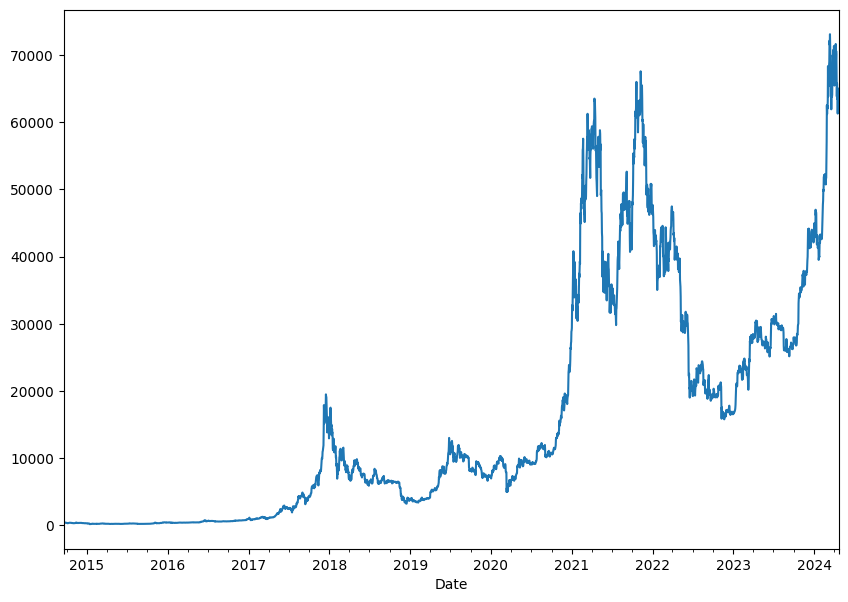

In [10]:
dataframe['Close'].plot(figsize=(10, 7));

In [11]:
# `btcc_prices` denotes the closing prices of BTC-USD.
btcc_prices = pd.DataFrame(dataframe["Close"].values, columns=["Price"], index=dataframe.index)
btcc_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [12]:
prices = btcc_prices['Price'].to_numpy()
prices

array([  457.334015,   424.440002,   394.79599 , ..., 63843.570313,
       64994.441406, 64773.386719])

In [13]:
# Normalizing the data
scaler = MinMaxScaler()

prices_normal = scaler.fit_transform(prices.reshape(-1, 1))
prices_normal

array([[0.00383005],
       [0.00337886],
       [0.00297225],
       ...,
       [0.87326138],
       [0.88904719],
       [0.88601512]])

In [14]:
# Create a plotting function
def plot_time_series(timestamps: List, values: List, format="-", start=0, end=None, title=None,
                     yLabel='BTC USD Close') -> None:
    """
    Plots a series of timestamps against values.

    Parameters
    ----------
    timestamps : list
        list of timestamp values
    values : list
        list of values across time
    format : str
        style of plot, default "."
    start : int
        starting index of the plot, ``start < len(timestamps)``
    end : int
        ending index of the plot, ``end < len(timestamps)``
    title : str
        label to show on plot of values
    """

    plt.plot(timestamps[start:end], values[start:end], format, label=title)
    plt.xlabel('Time')
    plt.ylabel(yLabel)
    if title:
        plt.legend(fontsize=14)
    plt.grid(True)


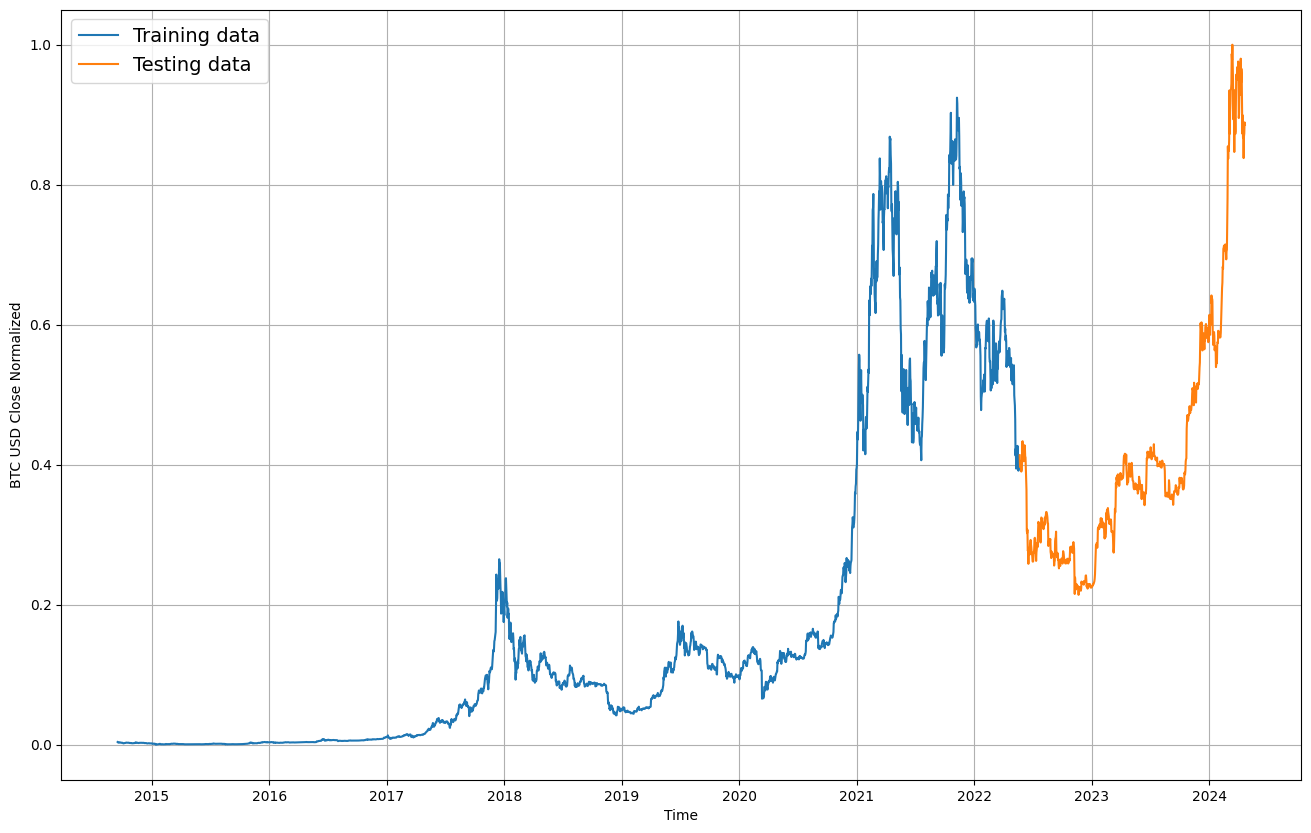

In [15]:
timestamps = btcc_prices.index.to_numpy()
training_data_len = int(.8 * len(btcc_prices))
test_data_len = len(btcc_prices) - training_data_len

plt.figure(figsize=(16, 10))
plot_time_series(timestamps=timestamps[:training_data_len], values=prices_normal[:training_data_len],
                 title="Training data")
plot_time_series(timestamps=timestamps[-test_data_len:], values=prices_normal[-test_data_len:], title="Testing data",
                 yLabel='BTC USD Close Normalized')

## Evaluation Metrics

In [16]:
def evaluate_pred(y_true: List, y_pred: List) -> Dict:
    """
    Performs various evaluation comparison functions on y_true labels and y_pred labels.

    Parameters
    ----------
    y_true : List
        true values
    y_pred : List
        predicted values

    Returns
    -------
    errors : dict
        dictionary containing the evaluation metrics, each metric is defined as a key-value pair where the key is the acronym for the metric in lowercase English.
    """
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)

    metric_results = {
        "mae": mae.numpy(),
        "mse": mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
    }
    return metric_results

## Create Windows

In [17]:
WINDOW_SIZE = 7
HORIZON = 1

In [18]:
def get_labelled_windows(x: List, horizon=HORIZON) -> Tuple:
    """
    Creates labels for windowed dataset.

    E.g. if horizon=1 (default)
    Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [19]:
def make_windows(x: List, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array of sequential data into a 2D array of windowed data.

    E.g.
    x before windowing: [1, 2, 3, 4, 5, 6, 7, 8] size = (8),
    x after windowing: [[1, 2, 3, 4, 5], [2, 3, 4, 5, 6], [3, 4, 5, 6, 7]] size = (3, 5)
    """

    window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)
    window_indices = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T
    windowed_array = x[window_indices]
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return tf.squeeze(windows), tf.squeeze(labels)

In [20]:
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.

    E.g. if len(windows) = 100, len(labels) = 100 and test_split = 0.2
    80 windows and labels will go to the training set and 20 will go to the test set.
    """
    split_size = int(len(windows) * (1 - test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

## Prepare Utilities for Training

In [21]:
# Create a Checkpoint & EarlyStopping callback

def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(save_path, model_name),
        verbose=0,
        save_best_only=True,
    )


def create_early_stopping(patience=3):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        restore_best_weights=True,
        verbose=1,
    )

## Model Experiments

1. FNN (Feed-forward, Densely Connected Network)
2. LSTM (Long Short-Term Memory)
3. Bi-LSTM (Bidirectional Long Short-Term Memory)
4. GRU (Gated Recurrent Unit)
5. Bi-GRU (Bidirectional Gated Recurrent Unit)
6. Conv1D (1-Dimensional Convolutional Neural Network)
7. N-BEATS (Neural Basis Expansion Analysis Time Series Model)

Each model will be trained and validated on the following window sizes and horizons:
- Window Size: 7, Horizon: 1
- Window Size: 7, Horizon: 7
- Window Size: 30, Horizon: 1
- Window Size: 30, Horizon: 7
- Window Size: 90, Horizon: 1
- Window Size: 90, Horizon: 7
- Window Size: 90, Horizon: 30

In [22]:
def fit_eval(
        model: tf.keras.models.Model,
        horizon=HORIZON,
        window=WINDOW_SIZE,
        epochs=100
) -> Tuple[List, Dict]:
    """
    Creates sliding windows for the given `WINDOW_SIZE` and `HORIZON`.
    Compiles and fits the model on the data for given number of `epochs`.
    Returns a dictionary of evaluation metrics.

    :param model: tf.keras.models.Model: the model to compile and fit
    :param horizon: int: the number of steps into the future to predict
    :param window: int: the number of timestamps to include in the input window
    :param epochs: int
    :return: a tuple containing the de-normalized predictions and a dictionary of evaluation metrics
    """

    # Clone the model to ensure a fresh copy is used
    model_clone = tf.keras.models.clone_model(model)
    train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
        *make_windows(
            prices_normal,
            window_size=window,
            horizon=horizon,
        ))

    model_clone.build(input_shape=(None, window))

    model_clone.add(tf.keras.layers.Dense(horizon, activation="linear"))

    model_clone.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["mae", "mse", "mape"])

    history = model_clone.fit(train_windows,
                              train_labels,
                              epochs=epochs,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[
                            create_model_checkpoint(
                                model_name=model_clone.name + "W" + str(window) + "H" + str(horizon)),
                            create_early_stopping(patience=8)
                        ])

    pd.DataFrame({"Validation MAPE": history.history['val_mape']}).plot(title="Validation MAPE", figsize=(8, 6))

    print("\n" + "-" * 20 + "\nEvaluating model on test data...")
    print(model_clone.evaluate(test_windows, test_labels, verbose=0))

    model_preds = model_clone.predict(test_windows)
    test_labels_inv = scaler.inverse_transform(tf.reshape(test_labels, shape=(-1, 1)))
    model_preds_inv = scaler.inverse_transform(tf.reshape(model_preds, shape=(-1, 1)))
    model_res = evaluate_pred(y_true=test_labels_inv, y_pred=model_preds_inv)

    return model_preds_inv, model_res


In [23]:
def save_model_plot(model: tf.keras.Model):
    """
    Saves the TF Model and a plot of the model to the filesystem.
    :param model:
    :return:
    """
    tf.keras.saving.save_model(model, os.path.join("model_experiments", model.name))
    tf.keras.utils.plot_model(
        model,
        show_shapes=True,
        show_layer_activations=True,
        to_file=os.path.join("model_experiments", model.name + ".png")
    )
    print(f"Model saved to: {os.path.join('model_experiments', model.name, '')}")
    print(f"Model plot saved to: {os.path.join('model_experiments', model.name + '.png')}")

### FNN (Feed-forward, Densely Connected Network)

In [24]:
model_fnn = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
], name="FNN")

#### FNN - Window Size 7, Horizon 1

Epoch 1/100
22/22 [==============================] - 3s 69ms/step - loss: 0.0344 - mae: 0.0344 - mse: 0.0063 - mape: 535.5062 - val_loss: 0.0132 - val_mae: 0.0132 - val_mse: 4.4249e-04 - val_mape: 3.1195
Epoch 2/100
22/22 [==============================] - 0s 5ms/step - loss: 0.0091 - mae: 0.0091 - mse: 3.2051e-04 - mape: 1099.2008 - val_loss: 0.0133 - val_mae: 0.0133 - val_mse: 4.0971e-04 - val_mape: 3.2430
Epoch 3/100
22/22 [==============================] - 1s 38ms/step - loss: 0.0081 - mae: 0.0081 - mse: 2.8260e-04 - mape: 851.1758 - val_loss: 0.0124 - val_mae: 0.0124 - val_mse: 3.8703e-04 - val_mape: 2.9297
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0077 - mae: 0.0077 - mse: 2.5672e-04 - mape: 453.6567 - val_loss: 0.0167 - val_mae: 0.0167 - val_mse: 5.5951e-04 - val_mape: 3.8529
Epoch 5/100
22/22 [==============================] - 1s 39ms/step - loss: 0.0080 - mae: 0.0080 - mse: 2.4275e-04 - mape: 502.7931 - val_loss: 0.0121 - val_mae: 0.0121 - val_

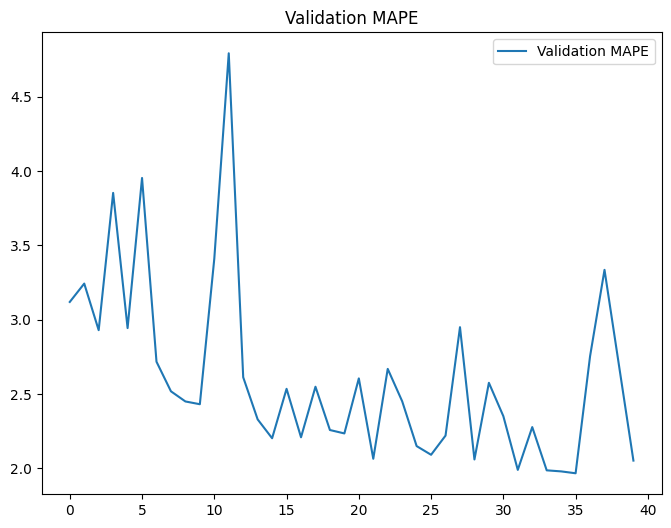

In [25]:
model_fnn_w7h1_preds_inv, model_fnn_w7h1_res = fit_eval(model_fnn, horizon=1, window=7, epochs=100)

In [26]:
model_fnn_w7h1_res

{'mae': 623.6756, 'mse': 1019177.94, 'rmse': 623.6756, 'mape': 1.9768424}

#### FNN - Window Size 7, Horizon 7

Epoch 1/100
22/22 [==============================] - 2s 55ms/step - loss: 0.1508 - mae: 0.1508 - mse: 0.0718 - mape: 3582.9331 - val_loss: 0.3272 - val_mae: 0.3272 - val_mse: 0.1366 - val_mape: 77.5112
Epoch 2/100
22/22 [==============================] - 1s 53ms/step - loss: 0.1024 - mae: 0.1024 - mse: 0.0385 - mape: 9856.8174 - val_loss: 0.1731 - val_mae: 0.1731 - val_mse: 0.0556 - val_mape: 39.8278
Epoch 3/100
22/22 [==============================] - 1s 53ms/step - loss: 0.0488 - mae: 0.0488 - mse: 0.0112 - mape: 8363.1250 - val_loss: 0.0532 - val_mae: 0.0532 - val_mse: 0.0071 - val_mape: 12.0594
Epoch 4/100
22/22 [==============================] - 1s 37ms/step - loss: 0.0183 - mae: 0.0183 - mse: 0.0014 - mape: 1881.2679 - val_loss: 0.0288 - val_mae: 0.0288 - val_mse: 0.0016 - val_mape: 7.1813
Epoch 5/100
22/22 [==============================] - 1s 37ms/step - loss: 0.0143 - mae: 0.0143 - mse: 8.3650e-04 - mape: 1119.5427 - val_loss: 0.0239 - val_mae: 0.0239 - val_mse: 0.0014 - val_m

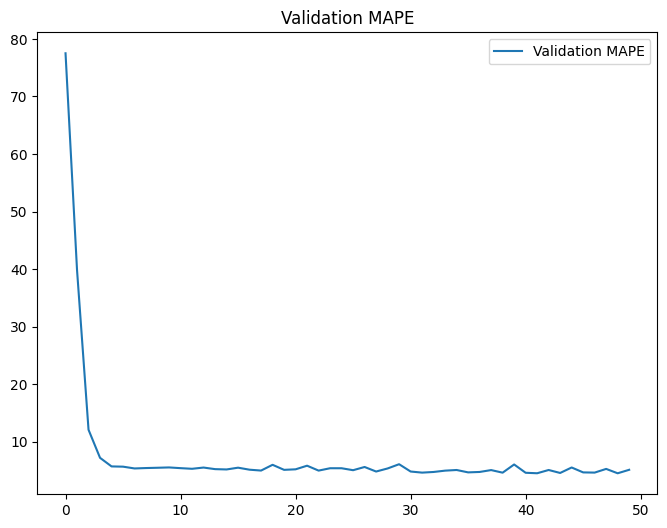

In [27]:
model_fnn_w7h7_preds_inv, model_fnn_w7h7_res = fit_eval(model_fnn, horizon=7, window=7, epochs=100)

In [28]:
model_fnn_w7h7_res

{'mae': 1371.9637, 'mse': 4602517.0, 'rmse': 1371.9637, 'mape': 4.4679575}

#### FNN - Window Size 30, Horizon 1

Epoch 1/100
22/22 [==============================] - 2s 48ms/step - loss: 0.0766 - mae: 0.0766 - mse: 0.0257 - mape: 2146.8604 - val_loss: 0.0311 - val_mae: 0.0311 - val_mse: 0.0022 - val_mape: 7.0673
Epoch 2/100
22/22 [==============================] - 1s 39ms/step - loss: 0.0197 - mae: 0.0197 - mse: 0.0012 - mape: 2499.2134 - val_loss: 0.0249 - val_mae: 0.0249 - val_mse: 0.0012 - val_mape: 6.2633
Epoch 3/100
22/22 [==============================] - 1s 39ms/step - loss: 0.0140 - mae: 0.0140 - mse: 7.5800e-04 - mape: 1064.0796 - val_loss: 0.0209 - val_mae: 0.0209 - val_mse: 9.1055e-04 - val_mape: 5.1002
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0122 - mae: 0.0122 - mse: 6.1206e-04 - mape: 640.7922 - val_loss: 0.0213 - val_mae: 0.0213 - val_mse: 8.5747e-04 - val_mape: 5.2983
Epoch 5/100
22/22 [==============================] - 1s 39ms/step - loss: 0.0112 - mae: 0.0112 - mse: 5.0415e-04 - mape: 301.1799 - val_loss: 0.0188 - val_mae: 0.0188 - val_mse: 7.85

{'mae': 728.07446, 'mse': 1225246.8, 'rmse': 728.07446, 'mape': 2.3549244}

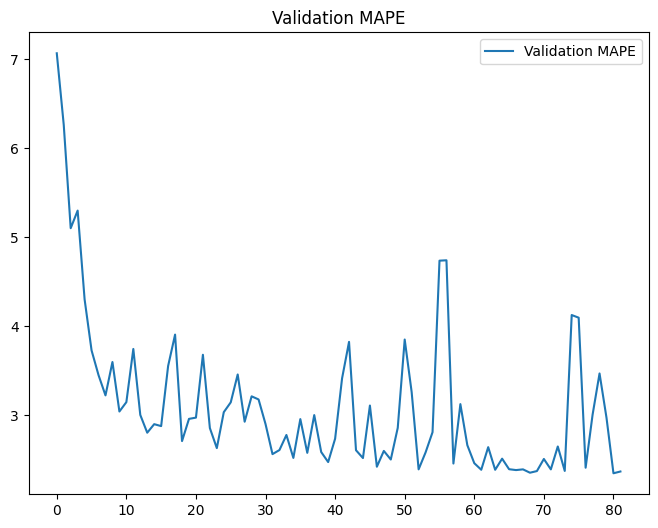

In [29]:
model_fnn_w30h1_preds_inv, model_fnn_w30h1_res = fit_eval(model_fnn, horizon=1, window=30, epochs=100)
model_fnn_w30h1_res

#### FNN - Window Size 30, Horizon 7

Epoch 1/100
22/22 [==============================] - 2s 49ms/step - loss: 0.1075 - mae: 0.1075 - mse: 0.0523 - mape: 5628.8511 - val_loss: 0.1148 - val_mae: 0.1148 - val_mse: 0.0365 - val_mape: 26.6301
Epoch 2/100
22/22 [==============================] - 1s 40ms/step - loss: 0.0361 - mae: 0.0361 - mse: 0.0051 - mape: 6675.4609 - val_loss: 0.0407 - val_mae: 0.0407 - val_mse: 0.0034 - val_mape: 9.7674
Epoch 3/100
22/22 [==============================] - 1s 37ms/step - loss: 0.0229 - mae: 0.0229 - mse: 0.0019 - mape: 2617.2288 - val_loss: 0.0343 - val_mae: 0.0343 - val_mse: 0.0026 - val_mape: 8.2094
Epoch 4/100
22/22 [==============================] - 1s 38ms/step - loss: 0.0195 - mae: 0.0195 - mse: 0.0016 - mape: 892.3744 - val_loss: 0.0329 - val_mae: 0.0329 - val_mse: 0.0025 - val_mape: 7.6875
Epoch 5/100
22/22 [==============================] - 1s 41ms/step - loss: 0.0181 - mae: 0.0181 - mse: 0.0014 - mape: 1160.5939 - val_loss: 0.0285 - val_mae: 0.0285 - val_mse: 0.0018 - val_mape: 6.

{'mae': 1352.8654, 'mse': 4480573.0, 'rmse': 1352.8654, 'mape': 4.418029}

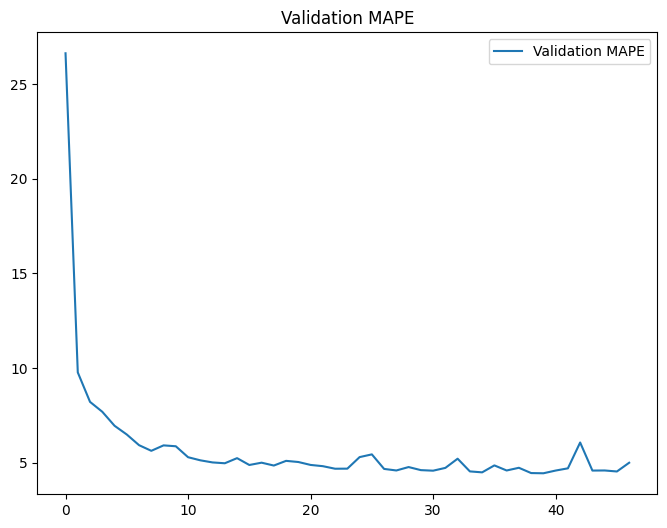

In [30]:
model_fnn_w30h7_preds_inv, model_fnn_w30h7_res = fit_eval(model_fnn, horizon=7, window=30, epochs=100)
model_fnn_w30h7_res

#### FNN - Window Size 90, Horizon 1

Epoch 1/100
22/22 [==============================] - 2s 69ms/step - loss: 0.1381 - mae: 0.1381 - mse: 0.0703 - mape: 4788.2485 - val_loss: 0.1968 - val_mae: 0.1968 - val_mse: 0.0771 - val_mape: 46.3346
Epoch 2/100
22/22 [==============================] - 1s 39ms/step - loss: 0.0605 - mae: 0.0605 - mse: 0.0183 - mape: 6893.8833 - val_loss: 0.0813 - val_mae: 0.0813 - val_mse: 0.0183 - val_mape: 18.8161
Epoch 3/100
22/22 [==============================] - 1s 39ms/step - loss: 0.0278 - mae: 0.0278 - mse: 0.0034 - mape: 3487.2681 - val_loss: 0.0300 - val_mae: 0.0300 - val_mse: 0.0020 - val_mape: 7.2731
Epoch 4/100
22/22 [==============================] - 1s 37ms/step - loss: 0.0181 - mae: 0.0181 - mse: 0.0012 - mape: 2092.9368 - val_loss: 0.0275 - val_mae: 0.0275 - val_mse: 0.0017 - val_mape: 6.5049
Epoch 5/100
22/22 [==============================] - 1s 45ms/step - loss: 0.0156 - mae: 0.0156 - mse: 0.0010 - mape: 1134.5255 - val_loss: 0.0254 - val_mae: 0.0254 - val_mse: 0.0015 - val_mape: 

{'mae': 1272.6711, 'mse': 3937185.2, 'rmse': 1272.6711, 'mape': 4.14302}

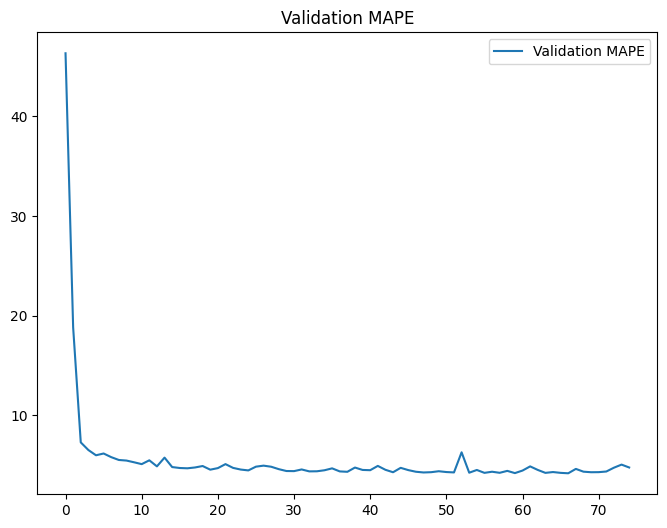

In [31]:
model_fnn_w90h1_preds_inv, model_fnn_w90h1_res = fit_eval(model_fnn, horizon=7, window=30, epochs=100)
model_fnn_w90h1_res

#### FNN - Window Size 90, Horizon 7

Epoch 1/100
22/22 [==============================] - 2s 49ms/step - loss: 0.1069 - mae: 0.1069 - mse: 0.0382 - mape: 10932.5049 - val_loss: 0.1223 - val_mae: 0.1223 - val_mse: 0.0296 - val_mape: 28.8512
Epoch 2/100
22/22 [==============================] - 1s 39ms/step - loss: 0.0378 - mae: 0.0378 - mse: 0.0049 - mape: 7724.8115 - val_loss: 0.0363 - val_mae: 0.0363 - val_mse: 0.0028 - val_mape: 8.3893
Epoch 3/100
22/22 [==============================] - 1s 39ms/step - loss: 0.0207 - mae: 0.0207 - mse: 0.0015 - mape: 1281.6075 - val_loss: 0.0307 - val_mae: 0.0307 - val_mse: 0.0021 - val_mape: 7.2673
Epoch 4/100
22/22 [==============================] - 1s 39ms/step - loss: 0.0177 - mae: 0.0177 - mse: 0.0013 - mape: 1098.6465 - val_loss: 0.0303 - val_mae: 0.0303 - val_mse: 0.0021 - val_mape: 6.9337
Epoch 5/100
22/22 [==============================] - 1s 43ms/step - loss: 0.0167 - mae: 0.0167 - mse: 0.0012 - mape: 561.1827 - val_loss: 0.0290 - val_mae: 0.0290 - val_mse: 0.0020 - val_mape: 6

{'mae': 1252.735, 'mse': 3849895.2, 'rmse': 1252.735, 'mape': 4.0932965}

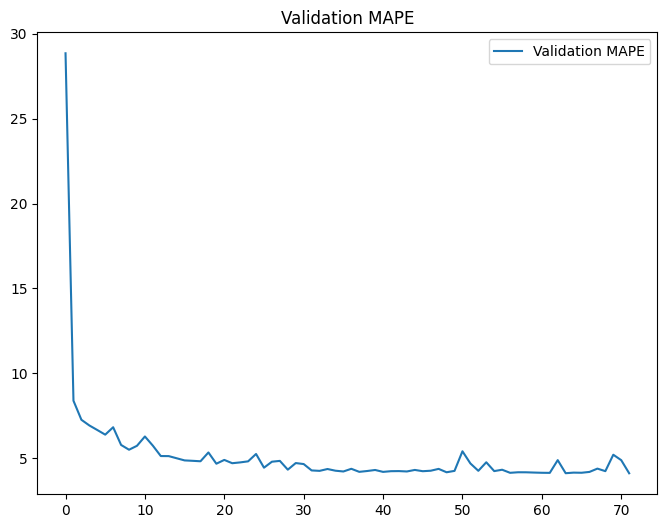

In [32]:
model_fnn_w90h7_preds_inv, model_fnn_w90h7_res = fit_eval(model_fnn, horizon=7, window=30, epochs=100)
model_fnn_w90h7_res

#### FNN - Window Size 90, Horizon 30

Epoch 1/100
22/22 [==============================] - 3s 70ms/step - loss: 0.1015 - mae: 0.1015 - mse: 0.0406 - mape: 7539.8066 - val_loss: 0.1515 - val_mae: 0.1515 - val_mse: 0.0542 - val_mape: 35.6604
Epoch 2/100
22/22 [==============================] - 1s 43ms/step - loss: 0.0491 - mae: 0.0491 - mse: 0.0123 - mape: 5817.9639 - val_loss: 0.0598 - val_mae: 0.0598 - val_mse: 0.0081 - val_mape: 13.6731
Epoch 3/100
22/22 [==============================] - 1s 40ms/step - loss: 0.0265 - mae: 0.0265 - mse: 0.0024 - mape: 3988.4861 - val_loss: 0.0341 - val_mae: 0.0341 - val_mse: 0.0026 - val_mape: 8.0906
Epoch 4/100
22/22 [==============================] - 1s 38ms/step - loss: 0.0185 - mae: 0.0185 - mse: 0.0014 - mape: 1524.2355 - val_loss: 0.0274 - val_mae: 0.0274 - val_mse: 0.0017 - val_mape: 6.5805
Epoch 5/100
22/22 [==============================] - 1s 47ms/step - loss: 0.0156 - mae: 0.0156 - mse: 0.0010 - mape: 482.4051 - val_loss: 0.0264 - val_mae: 0.0264 - val_mse: 0.0015 - val_mape: 6

{'mae': 1368.0256, 'mse': 4470100.0, 'rmse': 1368.0256, 'mape': 4.4355273}

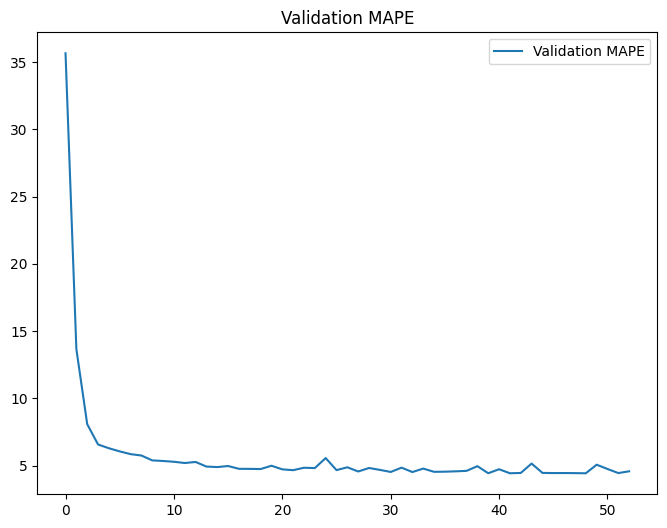

In [33]:
model_fnn_w90h30_preds_inv, model_fnn_w90h30_res = fit_eval(model_fnn, horizon=7, window=30, epochs=100)
model_fnn_w90h30_res

###GRU (Gated Recurrent Unit)

In [125]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.GRU(16, activation="relu")
], name="GRU")


###GRU - Window Size 7, Horizon 1

Epoch 1/100
22/22 [==============================] - 4s 124ms/step - loss: 0.1070 - mae: 0.1070 - mse: 0.0372 - mape: 13102.7119 - val_loss: 0.1068 - val_mae: 0.1068 - val_mse: 0.0168 - val_mape: 23.3919
Epoch 2/100
22/22 [==============================] - 2s 107ms/step - loss: 0.0250 - mae: 0.0250 - mse: 0.0022 - mape: 13500.8076 - val_loss: 0.0309 - val_mae: 0.0309 - val_mse: 0.0017 - val_mape: 7.1853
Epoch 3/100
22/22 [==============================] - 2s 90ms/step - loss: 0.0098 - mae: 0.0098 - mse: 3.9050e-04 - mape: 1009.2367 - val_loss: 0.0174 - val_mae: 0.0174 - val_mse: 5.9543e-04 - val_mape: 4.4011
Epoch 4/100
22/22 [==============================] - 2s 91ms/step - loss: 0.0087 - mae: 0.0087 - mse: 3.1416e-04 - mape: 637.4161 - val_loss: 0.0138 - val_mae: 0.0138 - val_mse: 4.7039e-04 - val_mape: 3.2113
Epoch 5/100
22/22 [==============================] - 2s 89ms/step - loss: 0.0083 - mae: 0.0083 - mse: 2.9608e-04 - mape: 645.0361 - val_loss: 0.0136 - val_mae: 0.0136 - val_mse

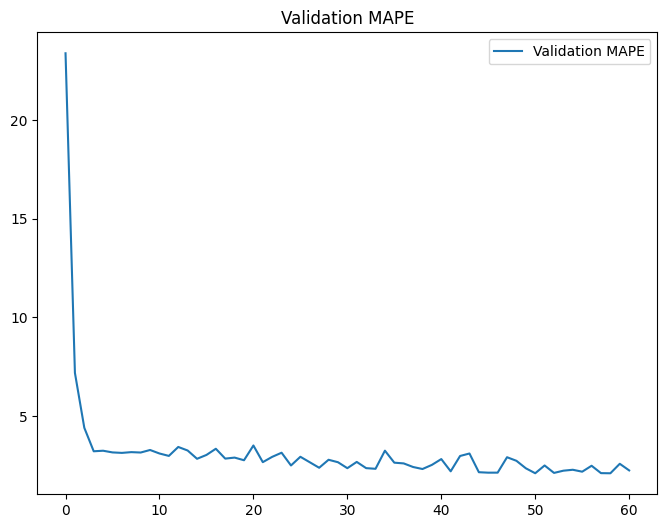

In [123]:
model_gru_w7h1_preds_inv, model_gru_w7h1_res = fit_eval(model_gru, horizon=1, window=7, epochs=100)

In [121]:
model_gru_w7h1_res

{'mae': 1071.9167, 'mse': 2724371.2, 'rmse': 1071.9167, 'mape': 3.5140624}

###GRU - Window Size 7, Horizon 7

Epoch 1/100
22/22 [==============================] - 4s 108ms/step - loss: 0.1267 - mae: 0.1267 - mse: 0.0498 - mape: 7331.3657 - val_loss: 0.2114 - val_mae: 0.2114 - val_mse: 0.0627 - val_mape: 49.0276
Epoch 2/100
22/22 [==============================] - 3s 123ms/step - loss: 0.0607 - mae: 0.0607 - mse: 0.0117 - mape: 16175.5820 - val_loss: 0.0477 - val_mae: 0.0477 - val_mse: 0.0054 - val_mape: 10.9779
Epoch 3/100
22/22 [==============================] - 2s 92ms/step - loss: 0.0198 - mae: 0.0198 - mse: 0.0015 - mape: 3788.1550 - val_loss: 0.0235 - val_mae: 0.0235 - val_mse: 0.0013 - val_mape: 5.5312
Epoch 4/100
22/22 [==============================] - 2s 89ms/step - loss: 0.0139 - mae: 0.0139 - mse: 8.2022e-04 - mape: 1382.0092 - val_loss: 0.0216 - val_mae: 0.0216 - val_mse: 0.0012 - val_mape: 5.0978
Epoch 5/100
22/22 [==============================] - 2s 90ms/step - loss: 0.0131 - mae: 0.0131 - mse: 7.8495e-04 - mape: 597.6440 - val_loss: 0.0214 - val_mae: 0.0214 - val_mse: 0.0012 - 

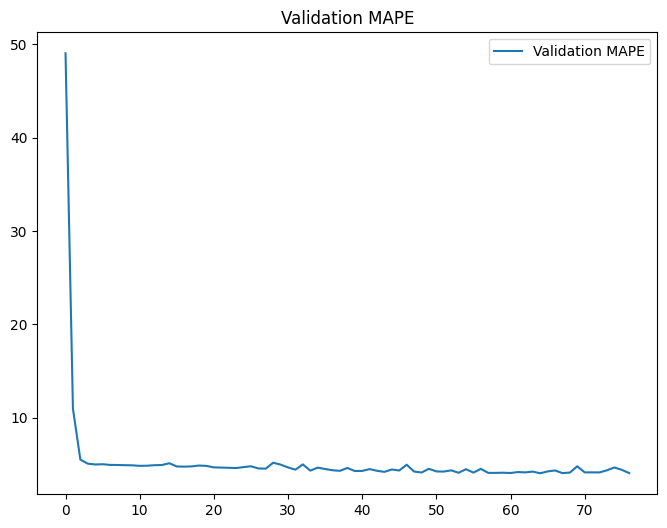

In [70]:
model_gru_w7h7_preds_inv, model_gru_w7h7_res = fit_eval(model_gru, horizon=7, window=7, epochs=100)

In [71]:
model_gru_w7h7_res

{'mae': 1267.9795, 'mse': 4073868.0, 'rmse': 1267.9795, 'mape': 4.114499}

###GRU - Window Size 30, Horizon 1

Epoch 1/100
22/22 [==============================] - 5s 108ms/step - loss: 0.0615 - mae: 0.0615 - mse: 0.0174 - mape: 6192.5425 - val_loss: 0.0746 - val_mae: 0.0746 - val_mse: 0.0079 - val_mape: 17.7491
Epoch 2/100
22/22 [==============================] - 2s 117ms/step - loss: 0.0225 - mae: 0.0225 - mse: 0.0020 - mape: 916.8161 - val_loss: 0.0300 - val_mae: 0.0300 - val_mse: 0.0019 - val_mape: 7.0560
Epoch 3/100
22/22 [==============================] - 0s 15ms/step - loss: 0.0179 - mae: 0.0179 - mse: 0.0013 - mape: 1446.2488 - val_loss: 0.0311 - val_mae: 0.0311 - val_mse: 0.0020 - val_mape: 7.1794
Epoch 4/100
22/22 [==============================] - 2s 104ms/step - loss: 0.0162 - mae: 0.0162 - mse: 0.0011 - mape: 889.2336 - val_loss: 0.0291 - val_mae: 0.0291 - val_mse: 0.0018 - val_mape: 6.6896
Epoch 5/100
22/22 [==============================] - 2s 91ms/step - loss: 0.0144 - mae: 0.0144 - mse: 8.6942e-04 - mape: 532.3466 - val_loss: 0.0217 - val_mae: 0.0217 - val_mse: 0.0010 - val_map

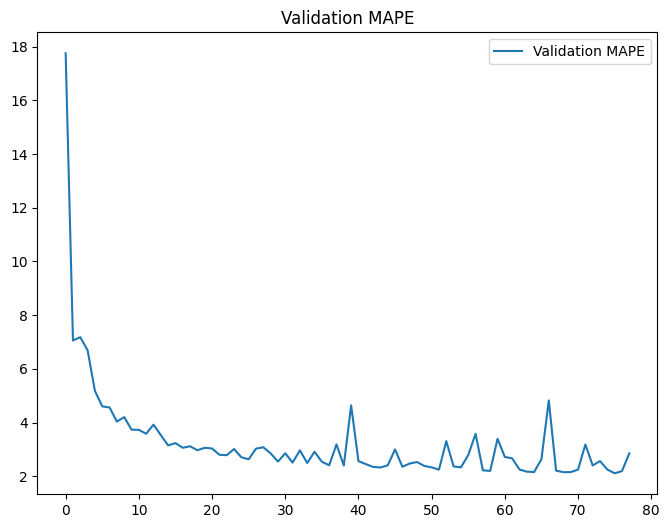

In [72]:
model_gru_w30h1_preds_inv, model_gru_w30h1_res = fit_eval(model_gru, horizon=1, window=30, epochs=100)

In [73]:
model_gru_w30h1_res

{'mae': 664.4876, 'mse': 1117528.2, 'rmse': 664.4876, 'mape': 2.1410105}

###GRU - Window Size 30, Horizon 7

Epoch 1/100
22/22 [==============================] - 5s 152ms/step - loss: 0.0797 - mae: 0.0797 - mse: 0.0253 - mape: 6388.9326 - val_loss: 0.0383 - val_mae: 0.0383 - val_mse: 0.0028 - val_mape: 9.5560
Epoch 2/100
22/22 [==============================] - 2s 92ms/step - loss: 0.0254 - mae: 0.0254 - mse: 0.0022 - mape: 4075.4604 - val_loss: 0.0374 - val_mae: 0.0374 - val_mse: 0.0028 - val_mape: 8.8363
Epoch 3/100
22/22 [==============================] - 2s 90ms/step - loss: 0.0201 - mae: 0.0201 - mse: 0.0017 - mape: 1106.2562 - val_loss: 0.0323 - val_mae: 0.0323 - val_mse: 0.0023 - val_mape: 7.5310
Epoch 4/100
22/22 [==============================] - 2s 91ms/step - loss: 0.0180 - mae: 0.0180 - mse: 0.0014 - mape: 926.4886 - val_loss: 0.0321 - val_mae: 0.0321 - val_mse: 0.0024 - val_mape: 7.2930
Epoch 5/100
22/22 [==============================] - 3s 123ms/step - loss: 0.0166 - mae: 0.0166 - mse: 0.0012 - mape: 621.1782 - val_loss: 0.0278 - val_mae: 0.0278 - val_mse: 0.0018 - val_mape: 6.

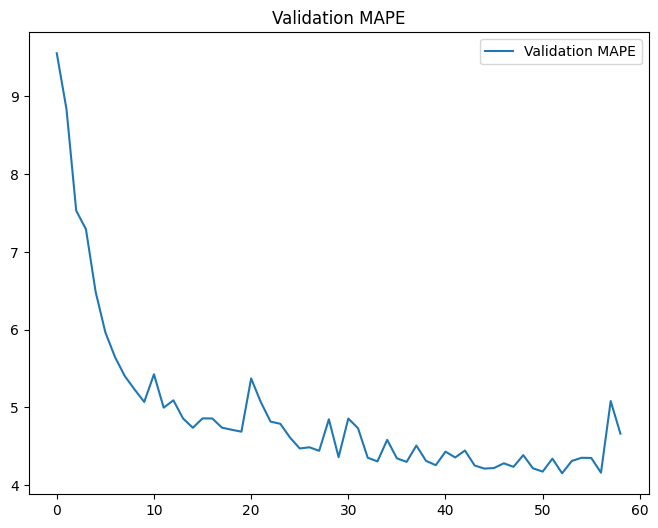

In [74]:
model_gru_w30h7_preds_inv, model_gru_w30h7_res = fit_eval(model_gru, horizon=7, window=30, epochs=100)

In [75]:
model_gru_w30h7_res

{'mae': 1272.32, 'mse': 4080602.5, 'rmse': 1272.32, 'mape': 4.145849}

###GRU - Window Size 90, Horizon 1

Epoch 1/100
22/22 [==============================] - 4s 106ms/step - loss: 0.0417 - mae: 0.0417 - mse: 0.0076 - mape: 4344.3984 - val_loss: 0.0447 - val_mae: 0.0447 - val_mse: 0.0041 - val_mape: 10.0248
Epoch 2/100
22/22 [==============================] - 2s 92ms/step - loss: 0.0201 - mae: 0.0201 - mse: 0.0016 - mape: 730.8289 - val_loss: 0.0304 - val_mae: 0.0304 - val_mse: 0.0018 - val_mape: 7.4222
Epoch 3/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0172 - mae: 0.0172 - mse: 0.0011 - mape: 1238.8536 - val_loss: 0.0420 - val_mae: 0.0420 - val_mse: 0.0032 - val_mape: 9.5497
Epoch 4/100
22/22 [==============================] - 2s 94ms/step - loss: 0.0172 - mae: 0.0172 - mse: 0.0011 - mape: 967.5012 - val_loss: 0.0303 - val_mae: 0.0303 - val_mse: 0.0018 - val_mape: 7.1606
Epoch 5/100
22/22 [==============================] - 3s 128ms/step - loss: 0.0151 - mae: 0.0151 - mse: 8.7091e-04 - mape: 766.7098 - val_loss: 0.0223 - val_mae: 0.0223 - val_mse: 0.0011 - val_mape:

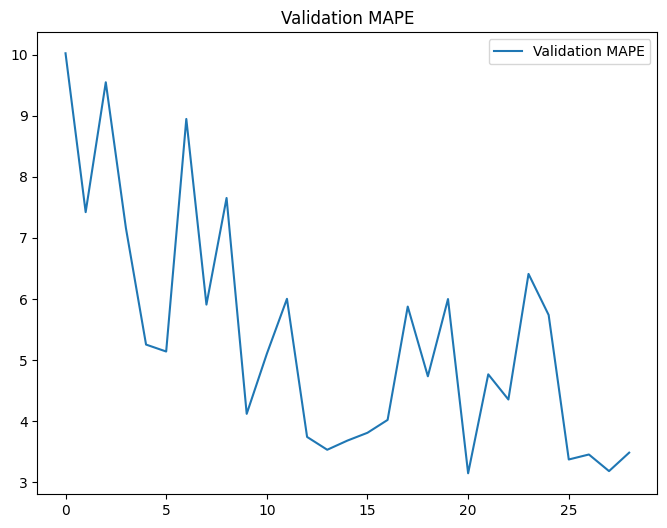

In [76]:
model_gru_w90h1_preds_inv, model_gru_w90h1_res = fit_eval(model_gru, horizon=1, window=90, epochs=100)

In [77]:
model_gru_w90h1_res

{'mae': 956.05054, 'mse': 2140462.0, 'rmse': 956.05054, 'mape': 3.1226587}

###GRU - Window Size 90, Horizon 7

Epoch 1/100
22/22 [==============================] - 4s 106ms/step - loss: 0.0688 - mae: 0.0688 - mse: 0.0197 - mape: 3439.8811 - val_loss: 0.0801 - val_mae: 0.0801 - val_mse: 0.0122 - val_mape: 17.9325
Epoch 2/100
22/22 [==============================] - 3s 157ms/step - loss: 0.0335 - mae: 0.0335 - mse: 0.0043 - mape: 1406.8494 - val_loss: 0.0461 - val_mae: 0.0461 - val_mse: 0.0044 - val_mape: 10.7854
Epoch 3/100
22/22 [==============================] - 2s 114ms/step - loss: 0.0228 - mae: 0.0228 - mse: 0.0019 - mape: 838.7257 - val_loss: 0.0379 - val_mae: 0.0379 - val_mse: 0.0026 - val_mape: 9.6995
Epoch 4/100
22/22 [==============================] - 2s 95ms/step - loss: 0.0210 - mae: 0.0210 - mse: 0.0016 - mape: 1061.9755 - val_loss: 0.0336 - val_mae: 0.0336 - val_mse: 0.0022 - val_mape: 8.3822
Epoch 5/100
22/22 [==============================] - 0s 9ms/step - loss: 0.0186 - mae: 0.0186 - mse: 0.0013 - mape: 652.3270 - val_loss: 0.0353 - val_mae: 0.0353 - val_mse: 0.0027 - val_mape: 

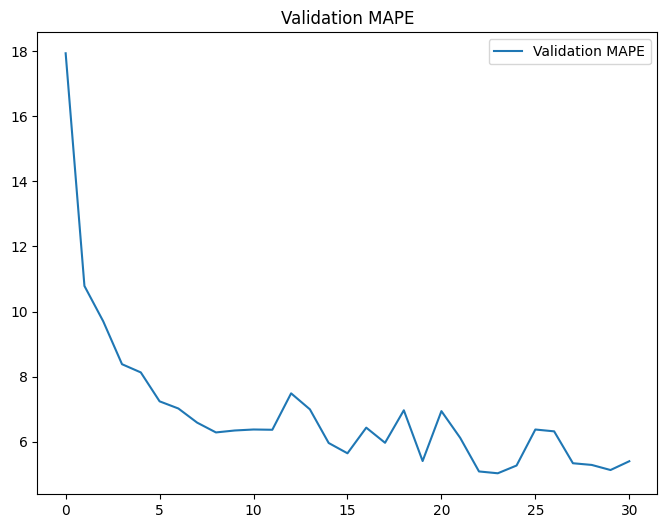

In [78]:
model_gru_w90h7_preds_inv, model_gru_w90h7_res = fit_eval(model_gru, horizon=7, window=90, epochs=100)

In [79]:
model_gru_w90h7_res

{'mae': 1522.3187, 'mse': 5403776.5, 'rmse': 1522.3187, 'mape': 5.0531926}

###GRU - Window Size 90, Horizon 30

Epoch 1/100
22/22 [==============================] - 4s 136ms/step - loss: 0.0809 - mae: 0.0809 - mse: 0.0265 - mape: 4526.6279 - val_loss: 0.0810 - val_mae: 0.0810 - val_mse: 0.0123 - val_mape: 19.5438
Epoch 2/100
22/22 [==============================] - 2s 97ms/step - loss: 0.0414 - mae: 0.0414 - mse: 0.0064 - mape: 3040.4172 - val_loss: 0.0660 - val_mae: 0.0660 - val_mse: 0.0094 - val_mape: 14.9751
Epoch 3/100
22/22 [==============================] - 3s 139ms/step - loss: 0.0326 - mae: 0.0326 - mse: 0.0041 - mape: 1065.7361 - val_loss: 0.0553 - val_mae: 0.0553 - val_mse: 0.0071 - val_mape: 12.6184
Epoch 4/100
22/22 [==============================] - 2s 95ms/step - loss: 0.0296 - mae: 0.0296 - mse: 0.0032 - mape: 1029.5961 - val_loss: 0.0549 - val_mae: 0.0549 - val_mse: 0.0072 - val_mape: 12.0638
Epoch 5/100
22/22 [==============================] - 2s 93ms/step - loss: 0.0279 - mae: 0.0279 - mse: 0.0029 - mape: 792.4067 - val_loss: 0.0480 - val_mae: 0.0480 - val_mse: 0.0054 - val_map

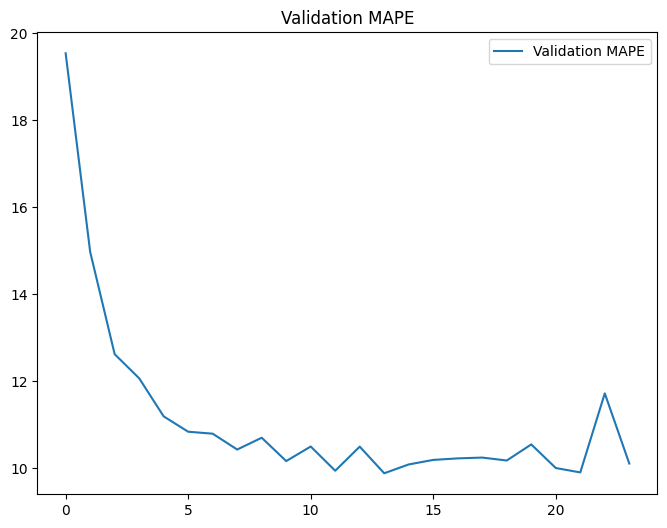

In [80]:
model_gru_w90h30_preds_inv, model_gru_w90h30_res = fit_eval(model_gru, horizon=30, window=90, epochs=100)

In [81]:
model_gru_w90h30_res

{'mae': 3054.7651, 'mse': 23838990.0, 'rmse': 3054.7651, 'mape': 10.113572}

###Bidirectional GRU (Gated Recurrent Unit)

In [147]:
model_bi_gru = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(16, activation="relu"))
], name="BiGRU")


###BiGRU - Window Size 7, Horizon 1

Epoch 1/100
22/22 [==============================] - 8s 257ms/step - loss: 0.0925 - mae: 0.0925 - mse: 0.0266 - mape: 11587.2998 - val_loss: 0.1223 - val_mae: 0.1223 - val_mse: 0.0189 - val_mape: 28.5151
Epoch 2/100
22/22 [==============================] - 7s 348ms/step - loss: 0.0266 - mae: 0.0266 - mse: 0.0023 - mape: 423.1309 - val_loss: 0.0200 - val_mae: 0.0200 - val_mse: 0.0012 - val_mape: 4.2172
Epoch 3/100
22/22 [==============================] - 0s 8ms/step - loss: 0.0110 - mae: 0.0110 - mse: 6.0447e-04 - mape: 746.0359 - val_loss: 0.0205 - val_mae: 0.0205 - val_mse: 7.7092e-04 - val_mape: 4.8503
Epoch 4/100
22/22 [==============================] - 5s 243ms/step - loss: 0.0088 - mae: 0.0088 - mse: 3.7547e-04 - mape: 552.9575 - val_loss: 0.0167 - val_mae: 0.0167 - val_mse: 6.5721e-04 - val_mape: 3.7810
Epoch 5/100
22/22 [==============================] - 6s 273ms/step - loss: 0.0086 - mae: 0.0086 - mse: 3.6028e-04 - mape: 313.6281 - val_loss: 0.0154 - val_mae: 0.0154 - val_mse: 

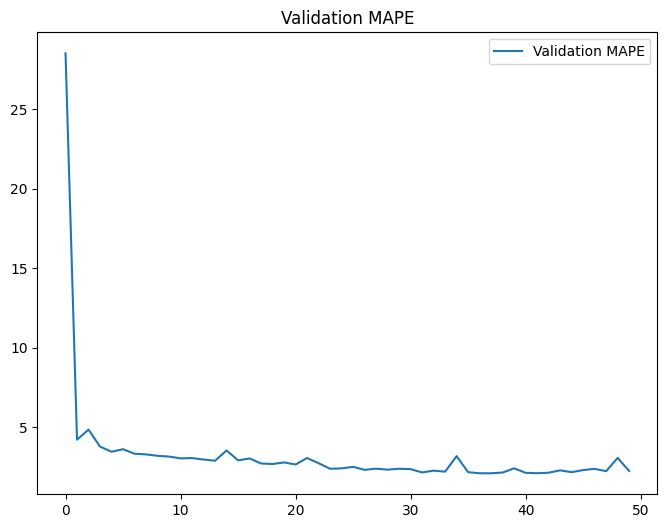

In [148]:
model_bi_gru_w7h1_preds_inv, model_bi_gru_w7h1_res = fit_eval(model_bi_gru, horizon=1, window=7, epochs=100)

###BiGRU - Window Size 90, Horizon 30


Epoch 1/100
22/22 [==============================] - 11s 289ms/step - loss: 0.1386 - mae: 0.1386 - mse: 0.0728 - mape: 3974.8821 - val_loss: 0.2494 - val_mae: 0.2494 - val_mse: 0.1204 - val_mape: 60.3999
Epoch 2/100
22/22 [==============================] - 5s 239ms/step - loss: 0.0862 - mae: 0.0862 - mse: 0.0369 - mape: 9069.2979 - val_loss: 0.1171 - val_mae: 0.1171 - val_mse: 0.0386 - val_mape: 27.7110
Epoch 3/100
22/22 [==============================] - 6s 268ms/step - loss: 0.0531 - mae: 0.0531 - mse: 0.0120 - mape: 8116.6797 - val_loss: 0.0845 - val_mae: 0.0845 - val_mse: 0.0156 - val_mape: 19.0186
Epoch 4/100
22/22 [==============================] - 5s 231ms/step - loss: 0.0402 - mae: 0.0402 - mse: 0.0057 - mape: 5828.3345 - val_loss: 0.0656 - val_mae: 0.0656 - val_mse: 0.0087 - val_mape: 15.4064
Epoch 5/100
22/22 [==============================] - 7s 337ms/step - loss: 0.0339 - mae: 0.0339 - mse: 0.0041 - mape: 2661.7244 - val_loss: 0.0552 - val_mae: 0.0552 - val_mse: 0.0065 - va

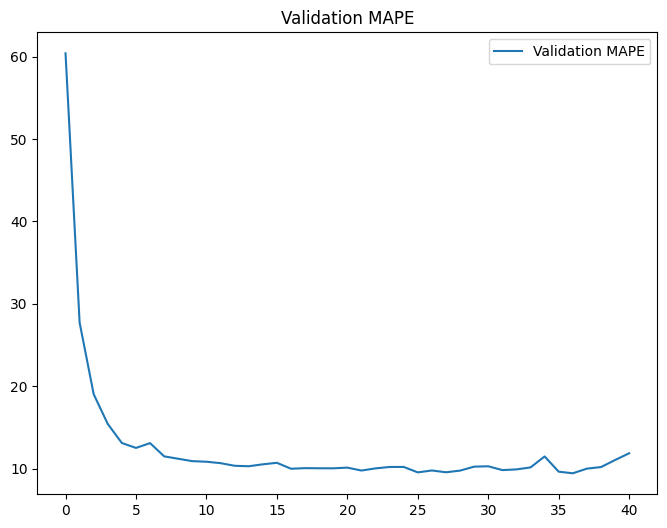

In [149]:
model_bi_gru_w90h30_preds_inv, model_bi_gru_w90h30_res = fit_eval(model_bi_gru, horizon=30, window=90, epochs=100)